In [30]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
import math
import time
import cmath
import sys
import os
import random

In [31]:
fs = 44100


In [50]:
def read(name):
    n_data = sf.read('auth/' + name + '_voice.wav')[0] # if use this, use n_data[0]
    print('play')
    sd.play(n_data, fs)
    sd.wait()
    return list(n_data)

def record(name):
    print('record')
    n_data = sd.rec(2 * fs, samplerate=fs, channels=1)
    sd.wait()
    print('play')
    sd.play(n_data, fs)
    sd.wait()
    sf.write('auth/' + name + '_voice.wav', n_data, samplerate=fs);
    return list(n_data)

In [33]:
def normalize_result(val):
    ln = len(val)
    ampl = [0] * ln
    arg = [0] * ln
    for i in range(0, len(val)):
        ampl[i] = abs(val[i]) / ln
        arg[i] = val[i].imag
    return ampl, arg

In [34]:
'''
slow version
 result = []
 for i in range(len(A)):
     result.append(complex(0))
     for j in range(len(A)):
         result[i] += A[j] * complex(math.cos(2 * math.pi * i * j / len(A)), -math.sin(2 * math.pi * i * j / len(A)))
 return result
'''
def fft(A):
    if len(A) == 1:
        return A
    assert len(A) % 2 == 0
    n =	len(A)
    a, b = [], []
    for i in range(0, n):
        if (i % 2 == 0):
            a.append(A[i].copy())
        else:
            b.append(A[i].copy())
    a = fft(a)
    b = fft(b)
    result = [complex(1) for _ in range(n)]
    pw = complex(1)
    w = complex(math.cos(2 * math.pi / n), math.sin(2 * math.pi / n))	
    for i in range(0, n // 2):
        tmp = pw * b[i]
        result[i] = a[i] + pw * b[i]
        result[i + n // 2] = a[i] - pw * b[i]
        pw *= w
    return result

In [35]:
def hamming(index, n):
    return 0.54 - 0.46 * math.cos((2 * math.pi * index) / (n - 1))

In [36]:
def find_peaks(arr, n, top_k=10):
    assert n > 200
    assert top_k <= n * 0.90
    result = []
    for i in range(int(n * 0.01), int(n * 0.99)):
        ok = True
        mn = arr[i]
        for j in range(int(-n * 0.01), int(n * 0.01)):
            idx = int(i + j)
            mn = min(arr[i + j], mn)
            if arr[idx] > arr[i]:
                ok = False
                break
        if ok and mn * 2 < arr[i]:
            result.append((arr[i] - mn * 2, i))
    return sorted(result)[::-1][:top_k]

In [37]:
def merge_similarities(arr, k = 10):
    n = len(arr)
    result = []
    arr.sort(key=lambda x: x[1])
    dp = [[-10**10 for j in range(k + 1)] for i in range(n + 1)]
    pre = [[(i - 1, i - 1, 0) for j in range(k + 1)] for i in range(n + 1)]
    dp[0][0] = 0
    for i in range(1, n + 1):
        for j in range(k, 0, -1):
            dp[i][j] = dp[i - 1][j]
            pre[i][j] = pre[i - 1][j]
            if dp[i][j - 1] > dp[i][j]:
                dp[i][j] = dp[i][j - 1]
                pre[i][j] = pre[i][j - 1]
            l = i - 1
            while l >= 0 and arr[i - 1][1] - arr[l][1] <= 50:
                l -= 1
                assert i >= 1
            calc = 0
            x_mean = 0
            sm = 0
            for f in range(l + 1, i):
                x_mean += arr[f][0] * arr[f][1]
                sm += arr[f][0]
            x_mean /= sm
            for f in range(l + 1, i):
                calc += arr[f][0] / 1.05 ** (abs(arr[f][1] - x_mean))
            if calc + dp[l][j - 1] > dp[i][j]:
                dp[i][j] = calc + dp[l][j - 1]
                pre[i][j] = (l, x_mean, -1)
    fin = [n, k]
    res = []
    while fin[1] >= 0 and fin[0] >= 0:
        pr = pre[fin[0]][fin[1]]
        if pr[2] != 0:
            res.append(pr[1])
        fin[0] = pr[0]
        fin[1] += pr[2]
    return res

In [38]:
def get_vector(name, iterations=5):
    data = np.array(read(name))
    plt.plot(data)
    plt.show()
    ln = len(data)
    new_ln = 1
    while new_ln < fs * 0.05:
        new_ln *= 2
    peaks = []
    for start_idx in range(iterations):
        start = random.randint(0, len(data) - new_ln)
        np_data = np.array(data)[start:start + new_ln]
        while True:
            if np_data.max() - np_data.min() > 0.05:
                break
            start = random.randint(0, len(data) - new_ln)
            np_data = np.array(data)[start:start + new_ln]
           
        np_data = fft(np_data)
        for i in range(len(np_data)):
            np_data[i] *= hamming(i, len(np_data))
        ampl, arg = normalize_result(np_data)
        
        '''
        to scale array from [???] to [0:5000]
        '''
        def get(arr, idx):
            k = 0.05 * 2
            if int(idx * k) == idx * k:
                return arr[int(idx * k)]
            diff = idx * k - int(idx * k)
            return arr[int(idx * k)] * diff + arr[int(idx * k) + 1] * (1 - diff)
        
        res = [get(ampl, i) for i in range(5000)]
        plt.plot(res, alpha=0.5)
        peaks.extend(find_peaks(res, len(res)))
    plt.show()
    return merge_similarities(peaks)

play


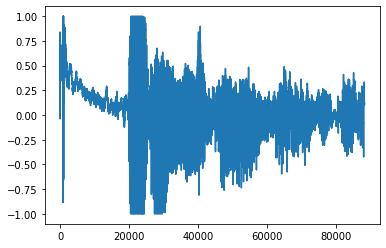

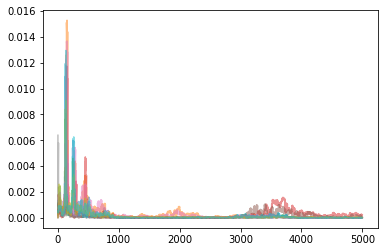

[3628.5685941520865,
 3519.5165932488653,
 3412.224178254592,
 763.778963205028,
 707.6654668949093,
 513.0161398174607,
 448.17949872615674,
 374.78685452035586,
 263.295638289198,
 137.0723544263063]

In [39]:
get_vector('kostya', 10)

play


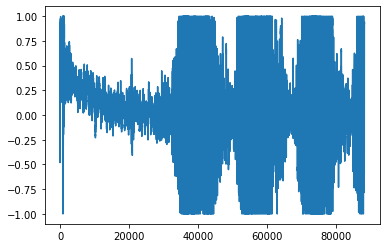

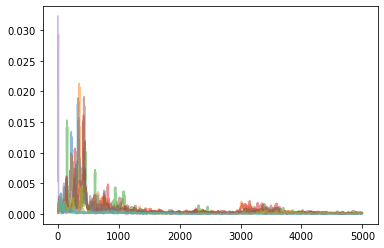

[1067.7436910757222,
 939.326445303119,
 759.4337637363665,
 611.8965130364891,
 430.5954100703905,
 335.58564194834184,
 280.0,
 217.0207881329162,
 122.334192643509,
 50.0]

In [40]:
get_vector('dima', 10)

In [41]:
def score(a, b):
    assert(len(a) == len(b))
    n = len(a)
    dp = [[10 ** 10 for i in range(n + 1)] for j in range(n + 1)]
    dp[0][0] = 0
    penalty = 100
    for i in range(n + 1):
        for j in range(n + 1):
            if i == 0 and j == 0:
                continue
            if i == 0:
                dp[i][j] = dp[i][j - 1] + penalty
            elif j == 0:
                dp[i][j] = dp[i - 1][j] + penalty
            else:
                dp[i][j]= min(min(dp[i - 1][j], dp[i][j - 1]) + penalty, dp[i - 1][j - 1] + abs(a[i - 1] - b[j - 1]))
    return dp[n][n]

play


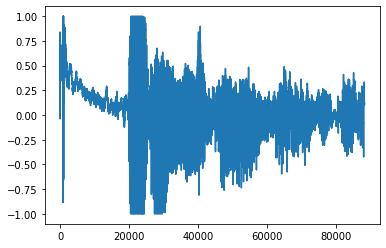

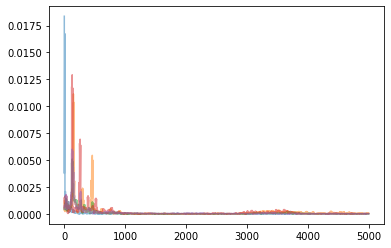

play


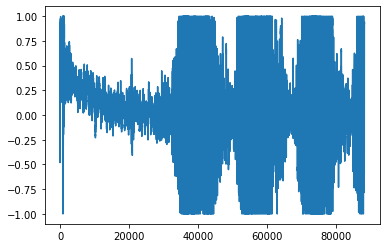

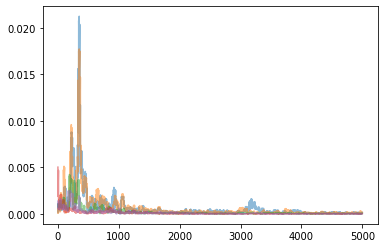

716.8683737660836

In [42]:
score(get_vector('kostya'), get_vector('dima'))

play


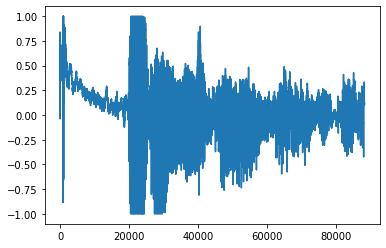

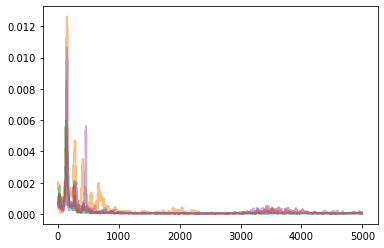

play


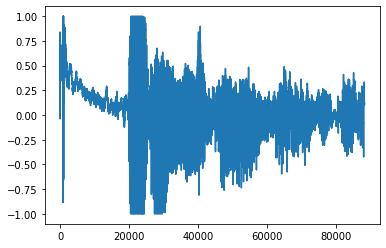

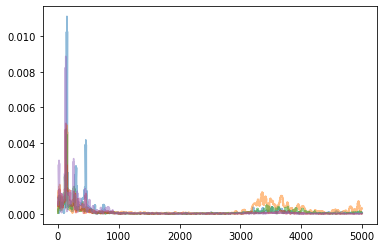

957.9963568814745

In [43]:
score(get_vector('kostya'), get_vector('kostya'))

play


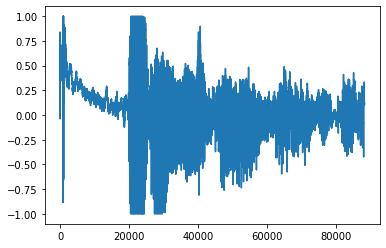

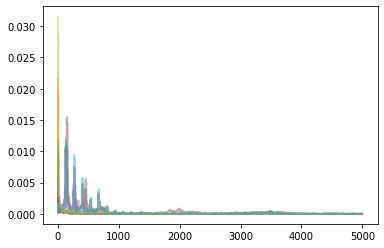

play


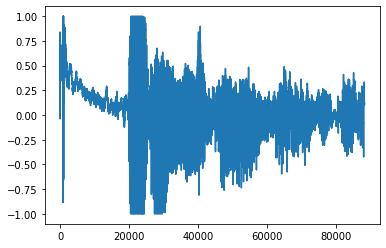

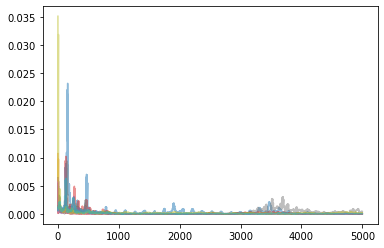

741.6613735959565

In [44]:
score(get_vector('kostya', 10), get_vector('kostya', 10))

play


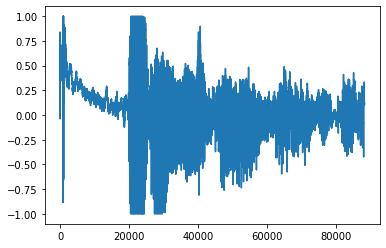

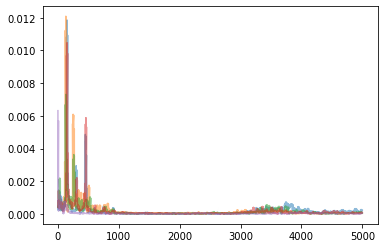

play


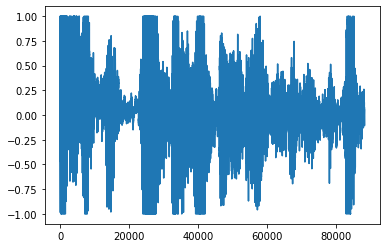

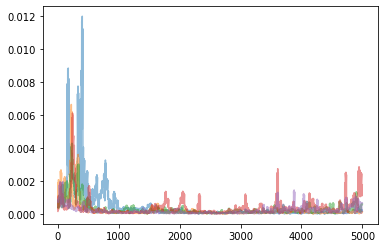

917.7807430925791

In [46]:
score(get_vector('kostya'), get_vector('roman'))

play


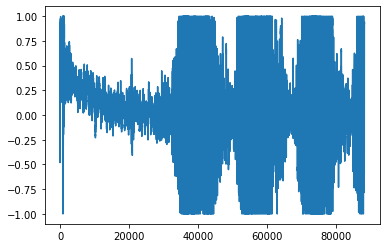

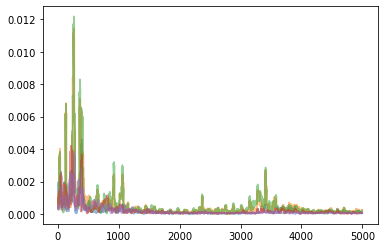

play


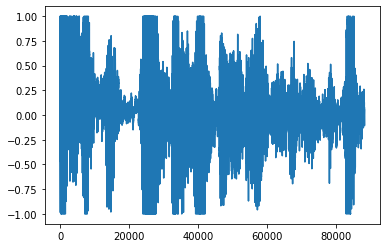

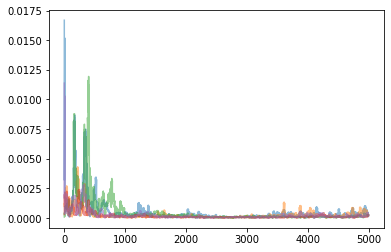

1065.7447443457147

In [47]:
score(get_vector('dima'), get_vector('roman'))

play


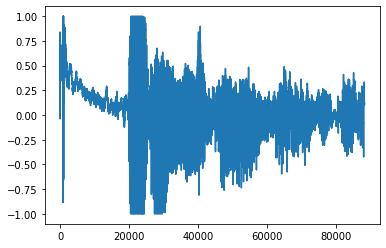

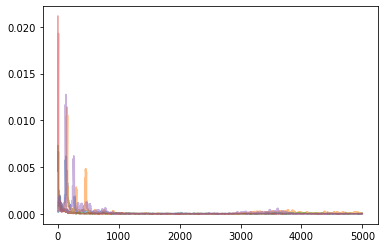

play


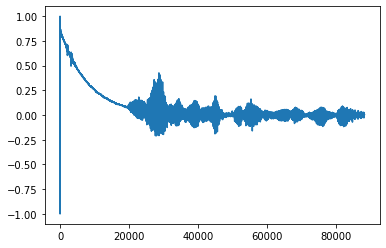

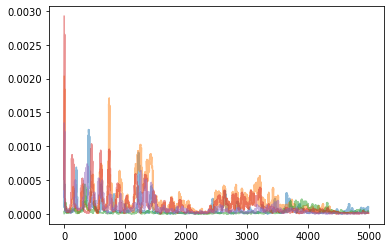

827.6458516712062

In [53]:
score(get_vector('kostya'), get_vector('kostya_2021'))